In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
import pandas as pd
import seaborn as sns
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn import neighbors, datasets
from sklearn.model_selection import cross_val_score
from sklearn.datasets import make_blobs
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from scipy.spatial import ConvexHull
from tqdm import tqdm
import random
plt.style.use('ggplot')
import pickle
from sklearn import tree
from sklearn.tree import export_graphviz
from joblib import dump, load
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
%matplotlib inline
from sklearn.impute import SimpleImputer
from scipy import interpolate
from scipy.interpolate import interp1d


In [2]:
MAX_DEPTH=6
NUMESTIMATORS=2

In [ ]:
Ef=pd.read_excel('./2022summer/adeptphase3/BIOTYPES_HC_withBiofactors_21_1008.xlsx')
Ef_=Ef[['DSM','DSM String']].dropna()
#Ef_=Ef['DSM'].dropna().astype(int)
Ef_.DSM=[int(x) for x in Ef_.DSM.values]
xf=pd.read_csv('./2022summer/adeptphase2/Cognition.csv',index_col=0)
xf.index.name='subject_id'
df=pd.read_csv('combined_bsnip.csv',index_col=0).drop('DSM',axis=1)
df=df.join(xf)#.head()
#df=df.join(Ef_.set_index('Subid'))

DELVAR=['project','BACS_COMP_Z']
cols=[x for x in df.columns if x not in DELVAR]
df=df[cols]

df=df.join(Ef_).dropna()#[['DSM','Biotype']]
df.DSM=df.DSM.values.astype(int)
df00=df.copy()#[['DSM','Biotype']]
df=df[df['DSM String']!='HC'].drop(['Biotype','DSM String'],axis=1)
#df=df.drop(['Biotype','DSM String'],axis=1)
df00#.DSM.value_counts()

In [6]:
def getAuc(X,y,test_size=0.25,max_depth=None,n_estimators=100,
           minsplit=4,FPR=[],TPR=[],VERBOSE=False, USE_ONLY=None):
    '''
        get AUC given training data X, with target labels y
    '''
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    CLASSIFIERS=[DecisionTreeClassifier(max_depth=max_depth, min_samples_split=minsplit,class_weight='balanced'),
                RandomForestClassifier(n_estimators=n_estimators,
                                       max_depth=max_depth,min_samples_split=minsplit,class_weight='balanced'),
                ExtraTreesClassifier(n_estimators=n_estimators,
                                     max_depth=max_depth,min_samples_split=minsplit,class_weight='balanced'),
                AdaBoostClassifier(n_estimators=n_estimators),
                GradientBoostingClassifier(n_estimators=n_estimators,max_depth=max_depth),
                svm.SVC(kernel='rbf',gamma='scale',class_weight='balanced',probability=True)]

    if USE_ONLY is not None:
        if isinstance(USE_ONLY, (list,)):
            CLASSIFIERS=[CLASSIFIERS[i] for i in USE_ONLY]
        if isinstance(USE_ONLY, (int,)):
            CLASSIFIERS=CLASSIFIERS[USE_ONLY]

    for clf in CLASSIFIERS:
        clf.fit(X_train,y_train)
        y_pred=clf.predict_proba(X_test)
        #print(X_test,y_pred)
        fpr, tpr, thresholds = metrics.roc_curve(y_test,y_pred[:,1], pos_label=1)
        auc=metrics.auc(fpr, tpr)
        if VERBOSE:
            print(auc)

        FPR=np.append(FPR,fpr)
        TPR=np.append(TPR,tpr)
    #points=np.array([[a[0],a[1]] for a in zip(FPR,TPR)])
    #hull = ConvexHull(points)
    #x=np.argsort(points[hull.vertices,:][:,0])
    auc=metrics.auc(fpr,tpr)
    return auc,CLASSIFIERS





def getAuc3(X,y,test_size=0.25,max_depth=None,n_estimators=100,
           minsplit=4,FPR=[],TPR=[],VERBOSE=False, USE_ONLY=None,LABELS=[1,2,3,5]):
    '''
        get AUC given training data X, with target labels y
    '''
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    CLASSIFIERS=[DecisionTreeClassifier(max_depth=max_depth, min_samples_split=minsplit,class_weight='balanced'),
                RandomForestClassifier(n_estimators=n_estimators,
                                       max_depth=max_depth,min_samples_split=minsplit,class_weight='balanced'),
                ExtraTreesClassifier(n_estimators=n_estimators,
                                     max_depth=max_depth,min_samples_split=minsplit,class_weight='balanced'),
                AdaBoostClassifier(n_estimators=n_estimators),
                GradientBoostingClassifier(n_estimators=n_estimators,max_depth=max_depth),
                svm.SVC(kernel='rbf',gamma='scale',class_weight='balanced',probability=True)]

    if USE_ONLY is not None:
        if isinstance(USE_ONLY, (list,)):
            CLASSIFIERS=[CLASSIFIERS[i] for i in USE_ONLY]
        if isinstance(USE_ONLY, (int,)):
            CLASSIFIERS=CLASSIFIERS[USE_ONLY]

    for clf in CLASSIFIERS:
        clf.fit(X_train,y_train)
        y_pred=clf.predict(X_test)
        #print(X_test,y_pred)
        #fpr, tpr, thresholds = metrics.roc_curve(y_test,y_pred[:,1], pos_label=1)
        #auc=metrics.auc(fpr, tpr)
        #if VERBOSE:
        #    print(auc)

        #FPR=np.append(FPR,fpr)
        #TPR=np.append(TPR,tpr)
    #points=np.array([[a[0],a[1]] for a in zip(FPR,TPR)])
    #hull = ConvexHull(points)
    #x=np.argsort(points[hull.vertices,:][:,0])
    #auc=metrics.auc(points[hull.vertices,:][x,0],points[hull.vertices,:][x,1])
    cf=confusion_matrix(np.array(y_test).astype(int),np.array(y_pred).astype(int),labels=LABELS)
    
    return cf,CLASSIFIERS


def saveFIG(filename='tmp.pdf',AXIS=False):
    '''
        save fig for publication
    '''
    import pylab as plt
    plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
            hspace = 0, wspace = 0)
    plt.margins(0,0)
    if not AXIS:
        plt.gca().xaxis.set_major_locator(plt.NullLocator())
        plt.gca().yaxis.set_major_locator(plt.NullLocator())
    plt.savefig(filename,dpi=300, bbox_inches = 'tight',
                pad_inches = 0,transparent=False) 
    return

In [7]:
def getacc(c1,c2,p1,p2,p3,f1,f2):
    s1=f1(1-c1)
    s2=f2(1-c2)
    A=(c1*c2*(1-p1)*(1-p2))/((c1*(1-p1)+(1-s1)*p1)*(c2*(1-p2)+(1-s2)*p2))
    B=(1-s1)*p1 - (1-c1)*(1-p1) + (1-s2)*p2 - (1-c2)*(1-p2) + p3
    return s1*p1+s2*p2+ A*B

In [8]:
def getCoverage(model,verbose=True):
    '''
        return how many distinct items (questions)
        are used in the model set.
        This includes the set of questions being
        covered by all forms that may be 
        generated by the model set
    '''
    FS=[]
    for m in model:
        for count in range(len(m.estimators_)):
            clf=m.estimators_[count]
            fs=clf.tree_.feature[clf.tree_.feature>0]
            FS=np.array(list(set(np.append(FS,fs))))
    if verbose:
        print("Number of items used: ", FS.size)
    return FS

def getConfusion(X,y,test_size=0.25,max_depth=None,n_estimators=100,
           minsplit=4,CONFUSION={},VERBOSE=False, USE_ONLY=None,target_names = None):
    '''
        get AUC given training data X, with target labels y
    '''
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    CLASSIFIERS=[DecisionTreeClassifier(max_depth=max_depth, min_samples_split=minsplit),
                RandomForestClassifier(n_estimators=n_estimators,class_weight='balanced',
                                       max_depth=max_depth,min_samples_split=minsplit),
                ExtraTreesClassifier(n_estimators=n_estimators,class_weight='balanced',
                                     max_depth=max_depth,min_samples_split=minsplit),
                AdaBoostClassifier(n_estimators=n_estimators),
                GradientBoostingClassifier(n_estimators=n_estimators,max_depth=max_depth),
                svm.SVC(kernel='rbf',gamma='scale',class_weight='balanced',probability=True)]

    if USE_ONLY is not None:
        if isinstance(USE_ONLY, (list,)):
            CLASSIFIERS=[CLASSIFIERS[i] for i in USE_ONLY]
        if isinstance(USE_ONLY, (int,)):
            CLASSIFIERS=CLASSIFIERS[USE_ONLY]

    for clf in CLASSIFIERS:
        clf.fit(X_train,y_train)
        y_pred=clf.predict(X_test)
        print(y_test,y_pred)
        cmat=confusion_matrix(y_test, y_pred)
        acc=accuracy_score(y_test, y_pred)
        
        CONFUSION[clf]=cmat
        
        if VERBOSE:
            print(classification_report(y_test, y_pred, target_names=target_names))
            print('Confusion MAtrix:\n', cmat)
            print(' ')
            print('Accuracy:', acc)

        
    return CONFUSION,acc,y_test,y_pred

In [9]:
def getFmap(CLFstar,X,y):
    auc_=[]
    ROC={}
    fpr_ = np.linspace(0, 1, num=20, endpoint=True)
    for run in np.arange(1000):
        clf=CLFstar
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)
        y_pred=clf.predict_proba(X_test)
        fpr, tpr, thresholds = metrics.roc_curve(y_test,y_pred[:,1], pos_label=1)
        f = interp1d(fpr, tpr)
        th = interp1d(fpr, thresholds)
        auc_=np.append(auc_,metrics.auc(fpr_, f(fpr_)))
        ROC[metrics.auc(fpr, tpr)]={'fpr':fpr_,'tpr':f(fpr_),'thresholds':th(fpr_)}

    TPR=[]
    for a in ROC.keys():
        TPR=np.append(TPR,ROC[a]['tpr'])
    TPR=TPR.reshape(int(len(TPR)/len(fpr_)),len(fpr_))
    medTPR=np.median(TPR,axis=0)
    return interpolate.interp1d(fpr_,np.median(TPR,axis=0) ), ROC

In [10]:
#df=df[df['Biotype']==3]
df=df.dropna()
df0=df
[p1,p2,p3]=(df0.DSM.value_counts()/df0.DSM.value_counts().sum()).values

In [11]:
df
#df.DSM.value_counts()
# 3 is HC

,panss_p1,panss_p2,panss_p3,panss_p4,panss_p5,panss_p6,panss_p7,panss_n1,panss_n2,panss_n3,...,ConsensusWRAT,Pro_NoGap_within_Impute_Age_Sex_adjusted,Pro_Gap_within_Impute_Age_Sex_adjusted,Pro_Overlap_within_Impute_Age_Sex_adjusted,Anti_Corr_Lat_within_Impute_Age_Sex_adjusted,Anti_Error_Lat_within_Impute_Age_Sex_adjusted,Anti_prop_error_within_Impute_Age_Sex_adjusted,SSGoDiff_standwithin,SSTProportionError_standwithin,DSM
subject_id,,,,,,,,,,,,,,,,,,,,,
53,4.0,3.0,5.0,2.0,1.0,3.0,1.0,5.0,1.0,1.0,...,84.0,0.71209,1.625000,1.195700,3.12500,0.18100,0.029824,-1.082237,1.224220,5
73,6.0,5.0,6.0,4.0,5.0,6.0,6.0,1.0,4.0,2.0,...,93.0,-1.70400,-1.294200,-0.096217,0.25845,-1.65310,0.617100,-2.243046,2.645965,2
92,1.0,1.0,1.0,1.0,3.0,4.0,2.0,1.0,2.0,3.0,...,65.0,-0.23966,-0.754990,0.037979,-0.22540,0.97479,-1.297900,1.389450,-0.624048,5
110,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,...,126.0,0.12837,0.218750,0.487910,-1.50000,0.99436,-1.353900,0.319242,-0.837310,5
116,3.0,1.0,5.0,2.0,1.0,3.0,1.0,4.0,3.0,1.0,...,96.0,0.49890,-0.093750,0.063904,1.00000,-0.49207,-1.324800,-2.103769,-0.197525,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2655,1.0,1.0,1.0,1.0,1.0,2.0,1.0,4.0,2.0,4.0,...,108.0,-0.21103,-0.068611,-0.187880,-0.90073,-0.59191,-0.820180,0.029065,-0.837310,5
2698,1.0,1.0,1.0,1.0,1.0,4.0,3.0,2.0,4.0,4.0,...,69.0,-0.31118,-0.715750,-0.330020,-0.47973,-1.16730,0.946400,0.991221,-1.050572,2
2699,3.0,1.0,1.0,3.0,2.0,4.0,3.0,1.0,4.0,1.0,...,99.0,-1.30120,-1.449800,-1.388200,-1.42070,-1.72170,2.437700,-0.217038,0.726609,2


In [10]:
def getRES(df0,MAX_DEPTH=6,NUMESTIMATORS=2,MODELfile='model123P1corrected.mod'):
    df=df0
    X=df.drop('DSM',axis=1).values
    y=df.DSM.values#.astype(str)
    y=[(int(x)==1)+0 for x in y ]

    MODEL={}
    
    ACC=[]
    CLFh={}
    for run in np.arange(500):
        auc,CLFS=getAuc(X,y,test_size=0.2,max_depth=MAX_DEPTH,n_estimators=NUMESTIMATORS,
                   minsplit=2,VERBOSE=False, USE_ONLY=[2])
        ACC=np.append(ACC,auc)
        if auc > 0.5:
            CLFh[auc]=CLFS
    CLFstar1=CLFh[np.array([k for k in CLFh.keys()]).max()][0]
    f0,ROC0=getFmap(CLFstar1,X,y)
    
    MODEL[1]={'estimator':CLFstar1,'fmap':f0,'rocs':ROC0}
    
    df=df0
    X=df.drop('DSM',axis=1).values
    y=df.DSM.values#.astype(str)
    y=[(int(x)==2)+0 for x in y ]

    
    ACC=[]
    CLFh={}
    for run in np.arange(500):
        auc,CLFS=getAuc(X,y,test_size=0.2,max_depth=MAX_DEPTH,n_estimators=NUMESTIMATORS,
                   minsplit=2,VERBOSE=False, USE_ONLY=[2])
        ACC=np.append(ACC,auc)
        if auc > 0.5:
            CLFh[auc]=CLFS
    CLFstarA=CLFh[np.array([k for k in CLFh.keys()]).max()][0]
    f1,ROCA=getFmap(CLFstarA,X,y)
    
    MODEL[2]={'estimator':CLFstarA,'fmap':f1,'rocs':ROCA}

    #df=df0[df0.Biotype.isin([1,5])]
    df=df0
    X=df.drop('DSM',axis=1).values
    y=df.DSM.values#.astype(str)
    y=[(int(x)==5)+0 for x in y ]

    ACC=[]
    CLFh={}
    for run in np.arange(500):
        auc,CLFS=getAuc(X,y,test_size=0.2,max_depth=MAX_DEPTH,n_estimators=NUMESTIMATORS,
                   minsplit=2,VERBOSE=False, USE_ONLY=[2])
        ACC=np.append(ACC,auc)
        if auc > 0.5:
            CLFh[auc]=CLFS
    CLFstarB=CLFh[np.array([k for k in CLFh.keys()]).max()][0]
    f2,ROCB=getFmap(CLFstarB,X,y)
    MODEL[5]={'estimator':CLFstarB,'fmap':f2,'rocs':ROCB}

    R=[]
    for i in np.arange(.7,.99,.01):
        for j in np.arange(.7,.99,.01):
            R=np.append(R,[i,j,getacc(i,j,p1,p2,p3,f1,f2)])
    R=pd.DataFrame(R.reshape(len(R)//3,3))
    R.columns=['c1','c2','acc']
    R['s1']=f1(1-R.c1)
    R['s2']=f2(1-R.c2)


    X_test=df.values.astype(np.float32)
    

    
    count=0
    threshold={}
    feature={}
    node_indicator={}
    leaf_id={}

    for i in CLFstarA.estimators_:
        #threshold[count]= i.tree_.threshold
        feature[count]= i.tree_.feature
        node_indicator[count] = i.tree_.decision_path(X_test)
        #leaf_id[count] = i.tree_.apply(X_testx)
        count=count+1

    for i in CLFstarB.estimators_:
        #threshold= i.tree_.threshold
        feature[count]= i.tree_.feature
        node_indicator[count] = i.tree_.decision_path(X_test)
        #leaf_id[count] = i.tree_.apply(X_test)
        count=count+1
        #for sample_id in np.arange(len(X_testx)):
        #    L=L+list(feature[node_indicator.indices[node_indicator.indptr[sample_id] : node_indicator.indptr[sample_id + 1]]][1:-1])
    
    L=[]
    for sample_id in np.arange(len(X_test)):
        for i in range(count-1):
            L=L+list(feature[i][node_indicator[i].indices[node_indicator[i].indptr[sample_id] : node_indicator[i].indptr[sample_id + 1]]][1:-1])
        #LL=np.append(LL,len(list(set(L))))
    L=list(set(L))
    


    RES=R.sort_values('acc',ascending=False).head(1)
    RES['nq_mean']=len(L)
    #RES['nq_median']=np.median(L)
    
    import dill
    with open(MODELfile, "wb") as dill_file:
        dill.dump(MODEL, dill_file)
    #dill_file.close()
    
    return RES, ROCA, ROCB, CLFstarA, CLFstarB



In [11]:
for i in tqdm(np.arange(5)):
    Rs,ROCa,ROCb,CLFstarA,CLFstarB=getRES(df0,MAX_DEPTH=10,MODELfile='model123P1DSM.mod_'+str(i))
    #Rs

100%|█████████████████████████████████████████████| 5/5 [00:45<00:00,  9.04s/it]


In [12]:
Rs

,c1,c2,acc,s1,s2,nq_mean
744,0.94,0.94,0.912485,1.0,0.864211,47


In [13]:
# load model
import dill
with open('model123P1DSM.mod_2','rb') as f:
    M=dill.load(f)

In [14]:
def getAvLen(clf):
    s=0
    v=0
    for e in clf.estimators_:
        a=' '.join(list(e.tree_.feature.astype(str))).split('-2')
        b=[len(x.split()) for x in a if x != ' ']
        s=s+np.array(b).sum()*(10/2**9)
        v=v+(np.array(b).std())**2
    return s,np.sqrt(v)

In [15]:
tt=M[1]['estimator']
s=0
for e in tt.estimators_:
    a=' '.join(list(e.tree_.feature.astype(str))).split('-2')
    b=np.array([len(x.split()) for x in a if x != ' '])
    s=s+b.mean()#np.array(b).sum()*(10/2**9)
s

3.9305555555555554

In [16]:
(10/2**9)

0.01953125

In [17]:
for i in [1,2,5]:
    print(getAvLen(M[i]['estimator']))
    

(1.6015625, 2.6500858942520296)
(1.46484375, 2.8432289069443475)
(1.54296875, 3.1365258525594113)


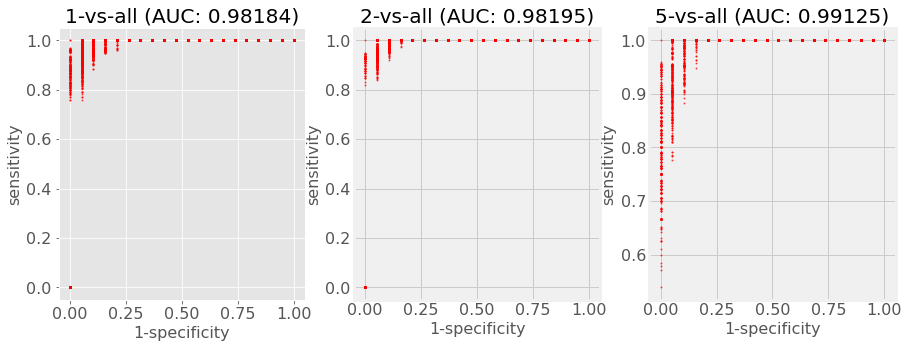

In [18]:
def pltROC(M,VAR,ax,FS=14):
    plt.style.use('fivethirtyeight')
    ROC=M[VAR]['rocs']   
    auc=[]
    for key,crv in ROC.items():
        ax.plot(crv['fpr'],crv['tpr'],'.',ms=2,color='r',alpha=.6)
        auc=np.append(auc,key)
    ax.set_xlabel('1-specificity',fontsize=FS)
    ax.set_ylabel('sensitivity',fontsize=FS)
    plt.setp(ax.get_xticklabels(), fontsize=FS);
    plt.setp(ax.get_yticklabels(), fontsize=FS);
    ax.set_title(str(VAR)+'-vs-all (AUC: '+ str(auc.mean())[:7]+')' );
    
#plt.style.use('seaborn-whitegrid')
fig=plt.figure(figsize=[15,5])
plt.subplot(1,3,1)
pltROC(M,1,plt.gca(),FS=16)

plt.subplot(1,3,2)
pltROC(M,2,plt.gca(),FS=16)

plt.subplot(1,3,3)
pltROC(M,5,plt.gca(),FS=16)

plt.savefig('ROC12vall_3vall_clinical_1DSM.png',dpi=400,bbox_inches='tight',transparent=True)


In [19]:
CF=np.zeros([3,3])
s2=Rs.s1.values[0]
s3=Rs.s2.values[0]
c2=Rs.c1.values[0]
c3=Rs.c2.values[0]
CF=[[c2*c3,1-c2,c2*(1-c3)],[(1-s2)*(1-s3),s2,(1-s2)*s3],[c2*(1-s3),1-c2,c2*s3]]

CF=pd.DataFrame(CF,columns=['D1','D2','D5'])
CF.index=CF.columns
CF

,D1,D2,D5
D1,0.883600,0.06,0.056400
D2,0.000000,1.00,0.000000
D5,0.127642,0.06,0.812358


In [20]:
df_=pd.read_csv('combined_bsnip.csv',index_col=0).drop('DSM',axis=1)
DELVAR=['project','BACS_COMP_Z']
cols=[x for x in df_.columns if x not in DELVAR]
df_=df_[cols]

len(df_.columns)

59

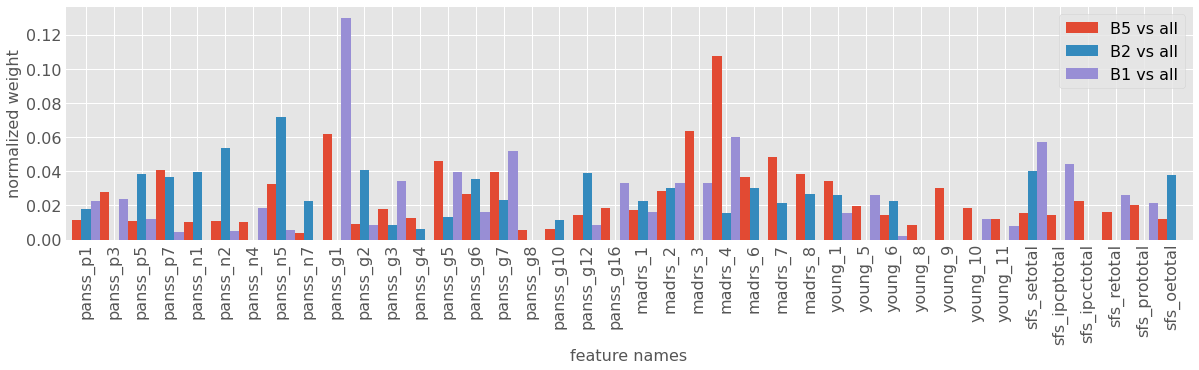

In [21]:
feature_names=df_.columns
feature_names=feature_names[1:]
FS=16
IMP1=M[1]['estimator'].feature_importances_
IMP2=M[2]['estimator'].feature_importances_
IMP5=M[5]['estimator'].feature_importances_
plt.style.use('fivethirtyeight')
plt.style.use('ggplot')
IMPdf=pd.DataFrame({'bio5_vs_all':IMP5,'bio2_vs_all':IMP2,'bio1_vs_all':IMP1})


IMPdf.index=feature_names
plt.figure(figsize=[18,4])
ax=IMPdf[IMPdf['bio5_vs_all']>0.003].plot(kind='bar',ax=plt.gca(),width=1)

ax.set_xlabel('feature names',fontsize=FS)
ax.set_ylabel('normalized weight',fontsize=FS)
plt.setp(ax.get_xticklabels(), fontsize=FS);
plt.setp(ax.get_yticklabels(), fontsize=FS);
#ax.set_title(str(VAR)+'-vs-all (AUC: '+ str(auc.mean())[:7]+')' );

ax.legend(['B5 vs all','B2 vs all','B1 vs all'],fontsize=FS)


plt.savefig('imp_small123P1xDSM.png',dpi=400,bbox_inches='tight',transparent=True)

In [22]:
IMPdf.sort_values('bio5_vs_all',ascending=False)

,bio5_vs_all,bio2_vs_all,bio1_vs_all
madrs_4,1.072858e-01,1.560987e-02,0.059987
madrs_3,6.331879e-02,0.000000e+00,0.032920
panss_g1,6.169661e-02,0.000000e+00,0.130006
madrs_7,4.815182e-02,2.161977e-02,0.000000
panss_g5,4.594148e-02,1.302661e-02,0.039330
panss_p7,4.106195e-02,3.648317e-02,0.004679
panss_g7,3.947273e-02,2.339945e-02,0.051844
madrs_8,3.851601e-02,2.691618e-02,0.000000
madrs_6,3.649619e-02,2.994902e-02,0.000000
young_1,3.459470e-02,2.639517e-02,0.015371


In [23]:
i1=IMPdf.sort_values('bio1_vs_all',ascending=False).head(10)
i2=IMPdf.sort_values('bio2_vs_all',ascending=False).head(10)
i3=IMPdf.sort_values('bio5_vs_all',ascending=False).head(10)
if_=pd.DataFrame({'B1_vs_all':i1.index,'B2_vs_all':i2.index,'B5_vs_all':i3.index})
if_.to_excel('imp123P1DSM.xls')

/tmp/ipykernel_1087076/2594665571.py:5: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  if_.to_excel('imp123P1DSM.xls')


In [24]:
RES=pd.concat([pd.concat([getRES(df0,MAX_DEPTH=m,MODELfile='tmpxx.mod')[0] for m in tqdm(np.arange(6,12))]) for run in tqdm(range(20))])

  0%|                                                     | 0/6 [00:00<?, ?it/s]/home/ishanu/.local/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1016: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(

 17%|███████▌                                     | 1/6 [00:09<00:46,  9.38s/it]/home/ishanu/.local/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1016: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(

 50%|██████████████████████▌                      | 3/6 [00:27<00:27,  9.18s/it]/home/ishanu/.local/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1016: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(

  0%|                                                     | 0/6 [00:00<?, ?it/s]/home/ishanu/.local/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1016: Und

  0%|                                                     | 0/6 [00:00<?, ?it/s]/home/ishanu/.local/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1016: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(

 83%|█████████████████████████████████████▌       | 5/6 [00:48<00:09,  9.76s/it]/home/ishanu/.local/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1016: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(

 83%|█████████████████████████████████████▌       | 5/6 [00:47<00:09,  9.60s/it]/home/ishanu/.local/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1016: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(

 67%|██████████████████████████████               | 4/6 [00:37<00:18,  9.46s/it]/home/ishanu/.local/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1016: Und

In [25]:
RES.to_csv('RESDSMstage1.csv',index=None)

In [26]:
RES

,c1,c2,acc,s1,s2,nq_mean
894,0.99,0.94,0.885101,0.768148,0.875202,36
624,0.90,0.94,0.874278,0.921528,0.849984,40
625,0.90,0.95,0.893355,0.982105,0.852778,42
895,0.99,0.95,0.918284,0.863510,0.891905,45
744,0.94,0.94,0.900072,0.949412,0.847038,49
...,...,...,...,...,...,...
894,0.99,0.94,0.905042,0.785533,0.959263,45
774,0.95,0.94,0.888481,0.921032,0.778328,41
779,0.95,0.99,0.938576,0.990000,0.793636,46
779,0.95,0.99,0.904874,0.901136,0.730931,42


Text(0, 0.5, 'mean accuracy')

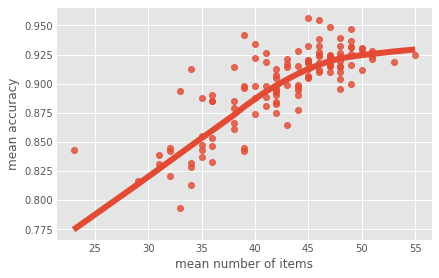

In [27]:
ax=sns.regplot(x=RES.nq_mean,y=RES.acc,ci=99.999,lowess=True)
ax.set_xlabel('mean number of items')
ax.set_ylabel('mean accuracy')
#plt.savefig('accvsitemnumber.png',dpi=200,bbox_inches='tight',transparent=True)

In [50]:
import scipy.stats as stats
import statsmodels.api as sm
from scipy import interpolate
from scipy.interpolate import interp1d
rf=pd.DataFrame(RES.set_index('nq_mean').acc)
rf.index=rf.index.astype(float)
rf=rf.sort_index()
DF=rf.copy()



plt.style.use('fivethirtyeight')
lowess = sm.nonparametric.lowess
S=.8
RUNS=30
for i in tqdm(range(RUNS)):
    X=rf.sample(int(np.round(S*rf.index.size))).sort_index().reset_index().values
    z = lowess(X[:,1], X[:,0], frac= .2)
    f = interp1d(z[:,0], z[:,1], fill_value="extrapolate")
    Y=f(DF.index.values)
    DF['run'+str(i)]=Y
STD=pd.DataFrame(3*(DF.std(axis=1)/np.sqrt(RUNS)))
Mf=pd.DataFrame(DF.mean(axis=1)).assign(sm=STD)
Mf.columns=['mn','sm']
ax=Mf.mn.plot(lw=1,color='k')
plt.fill_between(Mf.index,Mf.mn-Mf.sm,Mf.mn+Mf.sm,alpha=.5)  
#plt.fill_between(Mf.index,Mf.mn-Mf.sm,Mf.mn+Mf.sm,alpha=.35)
ax.set_xlabel('mean number of items')
ax.set_ylabel('mean accuracy')
plt.savefig('accvsitemnumberP1xDSM.png',dpi=200,bbox_inches='tight',transparent=True)


In [28]:
Mf[Mf.mn<.61]

NameError: name 'Mf' is not defined